In [ ]:
#Conduct compartmental analysis to study the transformation of compartments before and after infection.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess
import cooler
import cooltools.lib.plotting
import bioframe

In [10]:
resolution = 100000 
clr_mock_merge=cooler.Cooler('./merge/merge_7_17.cool')
clr_SARS_merge=cooler.Cooler('./merge/merge_8_18.cool')

In [11]:
#get GC content og genome
bins_mock = clr_mock_merge.bins()[:]
T2T_genome = bioframe.load_fasta('T2T-CoV2.fa');
## note the next command may require installing pysam
gc_cov = bioframe.frac_gc(bins_mock[['chrom', 'start', 'end']], T2T_genome)
gc_cov.to_csv('T2T_gc_cov_100kb.tsv',index=False,sep='\t')

display(gc_cov)

,chrom,start,end,GC
0,chr1,0,100000,0.454500
1,chr1,100000,200000,0.426020
2,chr1,200000,300000,0.439190
3,chr1,300000,400000,0.574690
4,chr1,400000,500000,0.625090
...,...,...,...,...
30557,chrX,154000000,154100000,0.379490
30558,chrX,154100000,154200000,0.397230
30559,chrX,154200000,154259566,0.499748
30560,chrM,0,16569,0.443720


In [13]:
#get chrom information
view_df = pd.DataFrame({'chrom': clr_mock_merge.chromnames,
                        'start': 0,
                        'end': clr_mock_merge.chromsizes.values,
                        'name': clr_mock_merge.chromnames}
                      )
display(view_df)

,chrom,start,end,name
0,chr1,0,248387328,chr1
1,chr2,0,242696752,chr2
2,chr3,0,201105948,chr3
3,chr4,0,193574945,chr4
4,chr5,0,182045439,chr5
5,chr6,0,172126628,chr6
6,chr7,0,160567428,chr7
7,chr8,0,146259331,chr8
8,chr9,0,150617247,chr9
9,chr10,0,134758134,chr10


In [14]:
# obtain first 3 eigenvectors

cis_eigs_mock = cooltools.eigs_cis(
                        clr_mock_merge,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )
cis_eigs_SARS = cooltools.eigs_cis(
                        clr_SARS_merge,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track_mock = cis_eigs_mock[1][['chrom','start','end','E1']]
eigenvector_track_SARS = cis_eigs_SARS[1][['chrom','start','end','E1']]

In [15]:
#f1 A to stronger A: (Mock-E1 - SARS-CoV-2-E1) < -0.2, Mock-E1>0.2;
#f2 B to A: (Mock E1 - SARS-CoV-2 E1) <-0.2, Mock-E1 < -0.2, SARS-CoV-2-E1>0;
#f3 B to weaker B: (Mock- E1 - SARS-CoV-2 E1) < -0.2, Mock-E1 <-0.2, SARS-CoV-2-E1<0;
#f4 B to stronger B: (Mock-E1 - SARS-CoV-2-E1)>0.2,Mock-E1 < -0.2;
#f5 A to B: (Mock-E1 - SARS-CoV-2-E1) > 0.2, Mock-E1 > 0.2, SARS-CoV-2-E1<0;
#f6 A to weaker A: (Mock-E1 - SARS-CoV-2-E1)> 0.2, Mock-E1 > 0.2, SARS-CoV-2-E1>0

type_list=["unchanged","A to stronger A","B to A","B to weaker B","B to stronger B","A to B","A to weaker A"]

f_list=[[], [], [], [], [], [], []]
m=eigenvector_track_mock['E1']
s=eigenvector_track_SARS['E1']

for i in range(len(m)):
    if not m.isnull()[i] and not s.isnull()[i]:
        if m[i]-s[i]<-0.2 and m[i]>0.2:
            f_list[1].append([m[i],s[i]])
        elif m[i]-s[i]<-0.2 and m[i]<-0.2 and s[i]>0:
            f_list[2].append([m[i],s[i]])
        elif m[i]-s[i]<-0.2 and m[i]<-0.2 and s[i]<0:
            f_list[3].append([m[i],s[i]])
        elif m[i]-s[i]>0.2 and m[i]<-0.2:
            f_list[4].append([m[i],s[i]])
        elif m[i]-s[i]> 0.2 and m[i] > 0.2 and s[i]<0:
            f_list[5].append([m[i],s[i]])
        elif m[i]-s[i]> 0.2 and m[i]>0.2 and s[i]>0:
            f_list[6].append([m[i],s[i]])
        else:
            f_list[0].append([m[i],s[i]])


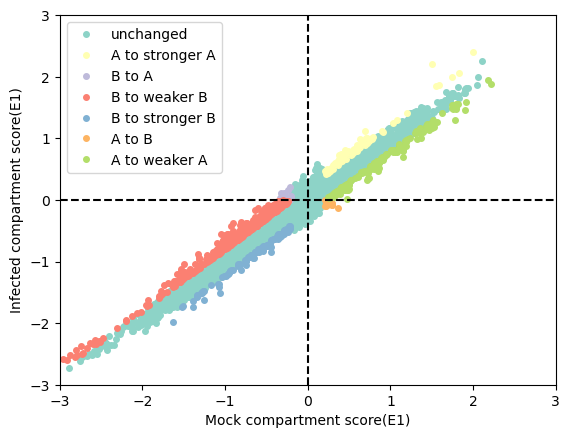

In [19]:
#draw the results

size=4
plt.cm.get_cmap('Paired')
color_list = plt.cm.Set3(np.linspace(0, 1, 12))

for i, f in enumerate(f_list):
    plt.plot(np.array(f)[:,0],np.array(f)[:,1],"o", color=color_list[i],markersize=size,label=type_list[i])

plt.plot([-3,3],[0,0],linestyle="--",linewidth=1.5,color="black")
plt.plot([0,0],[-3,3],linestyle="--",linewidth=1.5,color="black")

plt.legend()
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel("Mock compartment score(E1)")
plt.ylabel("Infected compartment score(E1)")

plt.savefig("./final_data/figS5C.pdf",format='pdf', dpi=1000, bbox_inches ="tight")
plt.show()
